# Emotion-Recognition Kaggle Model V2

## Note:

I will note include all the information about hardware and dataset, for reference check V1.

In [1]:
# Imports
import psutil as ps
import GPUtil as gpx
import platform
from tabulate import tabulate
from datetime import datetime
import seedir as sd
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dense, Input, Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
from keras.constraints import maxnorm

## Data Augmentation

In [2]:
# First the only data augmentation will be the horizontal flip, for further models I will add more complex transformation
training_datagen = ImageDataGenerator(horizontal_flip=True)
training_generator = training_datagen.flow_from_directory(
        '../../../datasets/kaggle_dataset_train/',
        target_size=(48, 48),
        batch_size=32,
        class_mode="categorical",
        color_mode="grayscale",
        shuffle=True,
        )

validation_datagen = ImageDataGenerator(horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        '../../../datasets/kaggle_dataset_test/',
        target_size=(48, 48),
        batch_size=32,
        class_mode="categorical",
        color_mode="grayscale",
        shuffle=True,
        )

Found 25839 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Neural Network Model

I'll try to reduce Pooling as much as possible and try with just 3 convo layers.

In [3]:
# Initialising the CNN
model = Sequential()

# Convolutional Layer N.1
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(48, 48,1)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Convolutional Layer N.2
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Convolutional Layer N.3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())


# Now we flatten the volume to pass it to the fully connected layers
model.add(Flatten())
# I also add another layer of dropout
model.add(Dropout(0.2))

# Now we create the first fully connected layer
# I also use maxnorm (kernel constraint) as it helps to regularize the data as it learns, this will help with overfitting
model.add(Dense(256, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Now we create the second fully connected layer
model.add(Dense(128, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Now we create the output [7 is the number of classes]
# We use softmax activation function since it selects the neuron with the highest probability as its output, voting that the image belongs to that class
model.add(Dense(7))
model.add(Activation('softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0

## Training

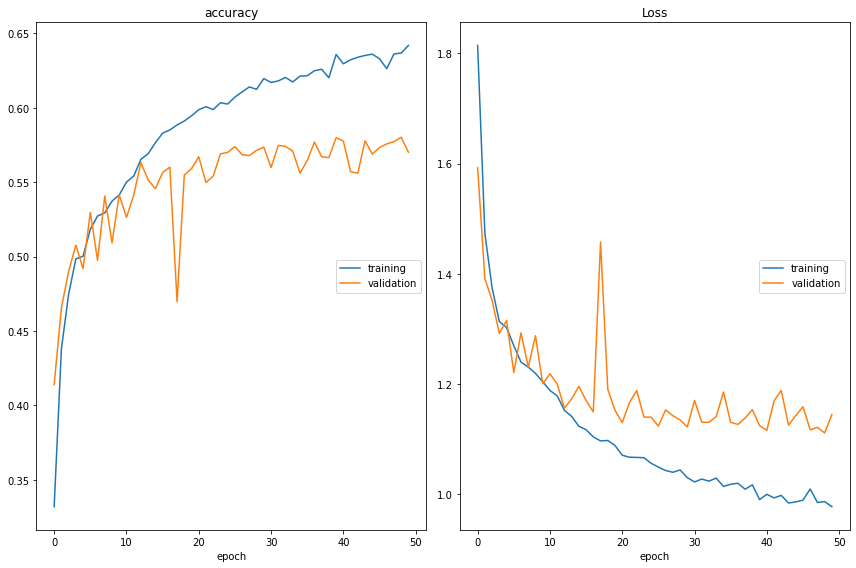

accuracy
	training         	 (min:    0.332, max:    0.642, cur:    0.642)
	validation       	 (min:    0.414, max:    0.580, cur:    0.570)
Loss
	training         	 (min:    0.978, max:    1.814, cur:    0.978)
	validation       	 (min:    1.112, max:    1.592, cur:    1.145)


In [4]:
# Now we compile the model and select the optimizer [tweak for how much time training will take]
model.compile(optimizer=Adam(lr=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])

# Setup how many epochs we want for each training and also how many steps per epoch
epochs = 50
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

callbacks = [PlotLossesKerasTF()]

print("Fit model on training data")
model_training = model.fit(
    x=training_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### Reuslts

This time both metrics are bad. We can state that the model is underfitting since the training accuracy is only 64%.

### Save the Model

In [5]:
model.save("kaggle_model_gen2.h5")

# serialize the model to json
model_json = model.to_json()
# save the model architecture to JSON file
with open("kaggle_model_gen2.json", "w") as json_file:
    json_file.write(model_json)

model_yaml = model.to_yaml()
with open("kaggle_model_gen2.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)